In [1]:
from bert_embedding import BertEmbedding
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from sklearn.decomposition import PCA
import pandas as pd
from scipy import spatial


# PLEASE NOTE
!python -V

Python 3.6.5 :: Anaconda, Inc.


In [2]:
db_file = './journal-database/database100_preprocessed.xlsx'

topics = {
  "mk": "Musculoskeletal Radiology",
  "ct": "Computed Tomography",
  "br": "Breast Imaging",
  "gu": "Geritourinary Radiology",
  "us": "Ultrasound",
  "ch": "Chest Radiology",
  "ir": "Interventional Radiology",
}

In [3]:
def read_abstracts(index):
    
    # format the input for bert-embedding
    
    # as an input bert takes one single string, with
    # each abstract separated with a newline \n
    
    if index in topics:
        data = np.array(pd.read_excel(db_file, sheet_name=index).abstract)
        
        string_of_abstracts = ""

        for abstract in data:
            string_of_abstracts += abstract
            string_of_abstracts += "\n"
        
        return string_of_abstracts

In [4]:
pca = PCA(n_components=2)

be_topic_results = []

pca_abstracts = []

non_pca_abstracts = []

for topic in topics:
    # format the input abstracts
    abstracts = read_abstracts(topic).split("\n")
    
    # format the input topics
    topic_title = ""
    for word in topics[topic].lower():
        topic_title += word
    topic_title += "\n"
    topic_title = topic_title.split("\n")
    
    
    # initialize the model
    be_model = BertEmbedding(model='bert_24_1024_16')
    
    # fetch word embeddings
    be_abst_result = be_model(abstracts)
    be_topic_result = be_model(topic_title)
    
    # add the be_result of the topic to a list
    be_topic_result = be_topic_result[:-1]
    be_topic_results.append(be_topic_result)
    
    
    # for some reason bert-embedding
    # returns an empty tuple in the last index
    # so it needs to be removed
    be_abst_result = be_abst_result[:-1]
    

    # bert-embedding returns 768 values
    # for each word so we
    # add them all into a list
    abstract_values = []
    for abstract in be_abst_result:
        word_values = []
        for word in abstract[1]:
            word_values.append(word)
        
        #calculate means for each abstract
        mean = np.mean(word_values, axis=0)
        abstract_values.append(mean)
    
    # perfrorm PCA for all the abstracts in topic
    two_dim_abstracts = pca.fit_transform(abstract_values)
    pca_abstracts.append(two_dim_abstracts)
    
    # extract non pca values for calculations
    non_pca_abstracts.append(abstract_values)

In [5]:
# calculate means for each topic

topic_values = []
for topic in be_topic_results:
    
    word_values = []
    
    for word in topic[0][1]:
        word_values.append(word)
        
    mean = np.mean(word_values, axis=0)
    topic_values.append(mean)
    

pca_topics = pca.fit_transform(topic_values)
    

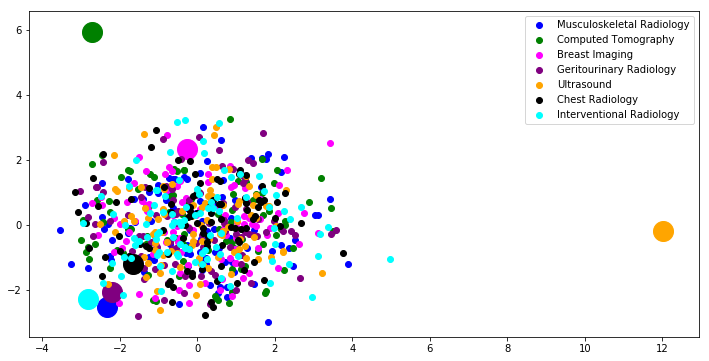

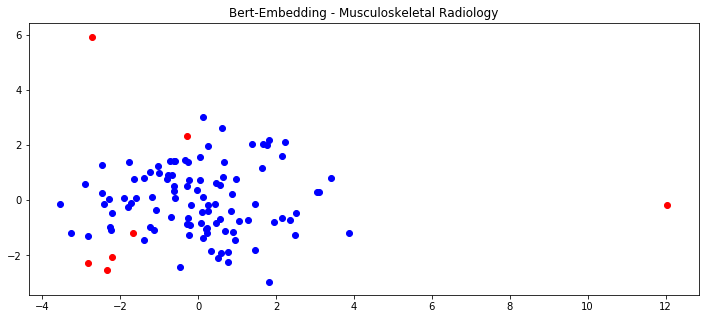

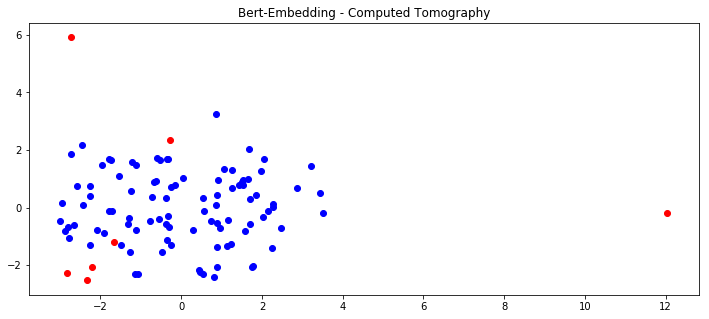

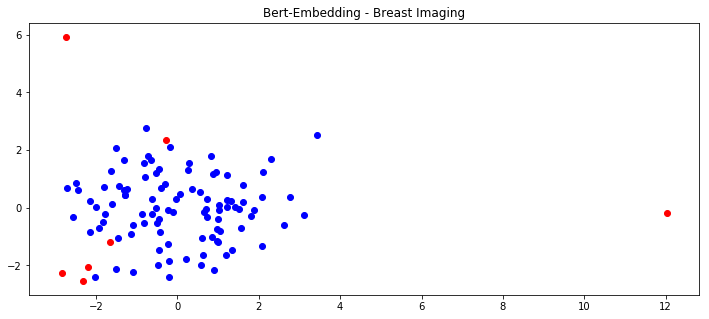

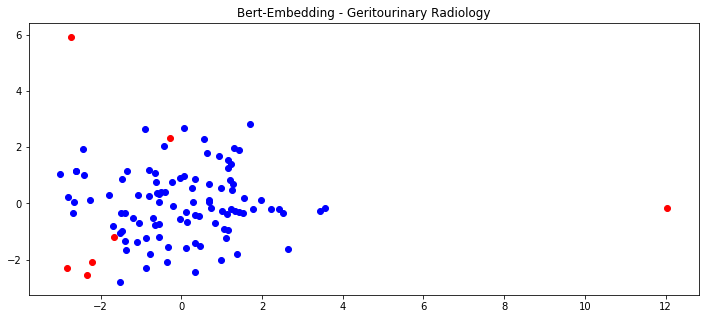

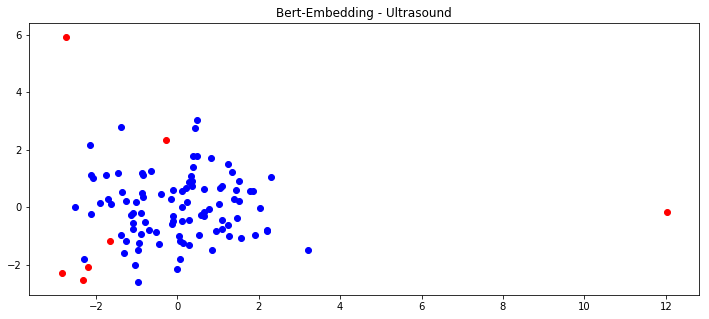

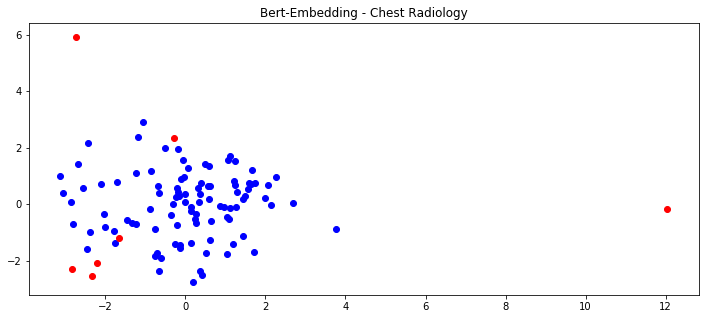

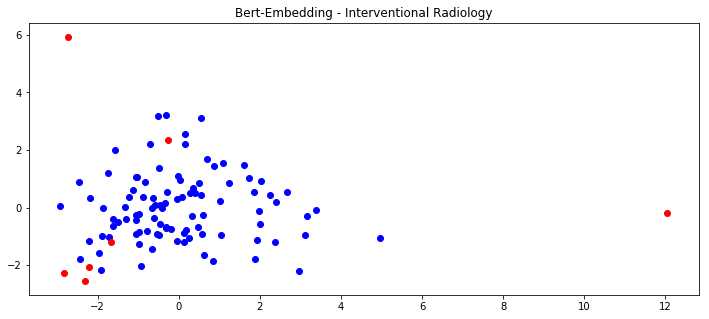

In [6]:
# visualize all the topics and abstracts in the same plot
plt.figure(figsize=(12,6))
plt.scatter(pca_abstracts[0][:, 0], pca_abstracts[0][:, 1], c='blue', label="Musculoskeletal Radiology")
plt.scatter(pca_topics[0][0], pca_topics[0][1], c='blue', s=400)

plt.scatter(pca_abstracts[1][:, 0], pca_abstracts[1][:, 1], c='green', label="Computed Tomography")
plt.scatter(pca_topics[1][0], pca_topics[1][1], c='green', s=400)

plt.scatter(pca_abstracts[2][:, 0], pca_abstracts[2][:, 1], c='magenta', label="Breast Imaging")
plt.scatter(pca_topics[2][0], pca_topics[2][1], c='magenta', s=400)

plt.scatter(pca_abstracts[3][:, 0], pca_abstracts[3][:, 1], c='purple', label="Geritourinary Radiology")
plt.scatter(pca_topics[3][0], pca_topics[3][1], c='purple', s=400)

plt.scatter(pca_abstracts[4][:, 0], pca_abstracts[4][:, 1], c='orange', label="Ultrasound")
plt.scatter(pca_topics[4][0], pca_topics[4][1], c='orange', s=400)

plt.scatter(pca_abstracts[5][:, 0], pca_abstracts[5][:, 1], c='black', label="Chest Radiology")
plt.scatter(pca_topics[5][0], pca_topics[5][1], c='black', s=400)

plt.scatter(pca_abstracts[6][:, 0], pca_abstracts[6][:, 1], c='cyan', label="Interventional Radiology")
plt.scatter(pca_topics[6][0], pca_topics[6][1], c='cyan', s=400)
plt.legend()

# visualize all the topics and all abstracts from one topic in one plot
for i, topic in enumerate(topics):
    plt.figure(figsize=(12, 5))
    plt.scatter(pca_abstracts[i][:, 0], pca_abstracts[i][:, 1], c='blue')
    for topic1 in pca_topics:
        plt.scatter(topic1[0], topic1[1], c='red')
    plt.title("Bert-Embedding - " + topics[topic])

In [7]:
def spatial_distance(vector1, vector2):
    return spatial.distance.euclidean(vector1, vector2)

def predict_correct_class(a_pca_vectors, topic_pca_vectors, correct_class):
    abstracts = []
    for i, vector in enumerate(a_pca_vectors):
        distances = []
        for topic in topic_pca_vectors:
            # euclidean distance between abstract and points
            distances.append(spatial_distance(vector,topic))
        abstracts.append(distances)
    right_wrong = [0,0]
    for distance in abstracts:
        if np.argmin(distance) == correct_class:
            right_wrong[0] += 1
        else: right_wrong[1] += 1
    return right_wrong

In [8]:
# Calculate euclidean distances to determine a "class" or topic
# for each abstract
#
# Non-PCA values used for calculations
# 
# Example:
# Right-Wrong: [40, 50]
# means that 40 abstracts would be classified in correct topic
# and 50 in wrong topic
# which equals to 40/90 = 0.44 = 44% classification success rate

right_wrongs = []
for i, abstract in enumerate(non_pca_abstracts):
    right_wrong = predict_correct_class(abstract, topic_values, i)
    right_wrong.append(i)
    right_wrongs.append(right_wrong)

accuracies = []
for i, topic in enumerate(topics):
    if i == right_wrongs[i][2]:
        print("\n" + topics[topic])
        print("Right-Wrong ", right_wrongs[i][:-1])
        print("Accuracy: ", round(right_wrongs[i][0]/(right_wrongs[i][0]+right_wrongs[i][1]), 4))
        accuracies.append(right_wrongs[i][0]/(right_wrongs[i][0]+right_wrongs[i][1]))

print("\nMean of accuracies: ", round(np.mean(accuracies), 4))


Musculoskeletal Radiology
Right-Wrong  [0, 100]
Accuracy:  0.0

Computed Tomography
Right-Wrong  [0, 96]
Accuracy:  0.0

Breast Imaging
Right-Wrong  [55, 43]
Accuracy:  0.5612

Geritourinary Radiology
Right-Wrong  [75, 24]
Accuracy:  0.7576

Ultrasound
Right-Wrong  [0, 96]
Accuracy:  0.0

Chest Radiology
Right-Wrong  [0, 99]
Accuracy:  0.0

Interventional Radiology
Right-Wrong  [1, 95]
Accuracy:  0.0104

Mean of accuracies:  0.1899
